### **Install yfinance & Torchvision**

In [37]:
pip install yfinance pandas numpy matplotlib scikit-learn torch torchvision

Note: you may need to restart the kernel to use updated packages.


### **Import the Library**

In [38]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

### **Download Historical Stock Data**

In [39]:
data = yf.download("AAPL", start="2020-01-01", end="2024-12-31", auto_adjust=True)
print(data)

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2020-01-02   72.620842   72.681289   71.373218   71.627092  135480400
2020-01-03   71.914818   72.676447   71.689957   71.847118  146322800
2020-01-06   72.487854   72.526541   70.783256   71.034717  118387200
2020-01-07   72.146935   72.753816   71.926907   72.497522  108872000
2020-01-08   73.307533   73.609768   71.849555   71.849555  132079200
...                ...         ...         ...         ...        ...
2024-12-23  254.655716  255.034791  252.840088  254.156919   40858800
2024-12-24  257.578674  257.588630  254.675658  254.875189   23234700
2024-12-26  258.396667  259.474086  257.010028  257.568678   27237100
2024-12-27  254.974930  258.077462  252.451019  257.209530   42355300
2024-12-30  251.593079  252.889953  250.146571  251.623005   35557500

[1257 rows x 5 colu

### **Clean the Column Index**

In [40]:
data.columns = data.columns.get_level_values(0)
data

Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,72.620842,72.681289,71.373218,71.627092,135480400
2020-01-03,71.914818,72.676447,71.689957,71.847118,146322800
2020-01-06,72.487854,72.526541,70.783256,71.034717,118387200
2020-01-07,72.146935,72.753816,71.926907,72.497522,108872000
2020-01-08,73.307533,73.609768,71.849555,71.849555,132079200
...,...,...,...,...,...
2024-12-23,254.655716,255.034791,252.840088,254.156919,40858800
2024-12-24,257.578674,257.588630,254.675658,254.875189,23234700
2024-12-26,258.396667,259.474086,257.010028,257.568678,27237100


### **Add features that help the model learn price trends.**

In [41]:
# Create lag and moving average features
data['Open_p'] = data['Open'].shift(1)
data['Close_Lag1'] = data['Close'].shift(1)
data['MA7'] = data['Close'].rolling(5).mean()
data['MA14'] = data['Close'].rolling(10).mean()
data = data.dropna()

X = data[['Open_p', 'Close_Lag1', 'MA7', 'MA14']]
y = data['Close']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

## **Linear Regression**

In [42]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

## **Random Forest**

In [43]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

### **LSTM with PyTorch**

In [44]:
close_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
close_scaled = scaler.fit_transform(close_prices)

def create_sequences(data, seq_length=60):
    xs, ys = [], []
    for i in range(seq_length, len(data)):
        xs.append(data[i-seq_length:i])
        ys.append(data[i])
    return np.array(xs), np.array(ys)

X_lstm, y_lstm = create_sequences(close_scaled)
split = int(len(X_lstm)*0.8)

X_train_lstm = torch.tensor(X_lstm[:split], dtype=torch.float32)
y_train_lstm = torch.tensor(y_lstm[:split], dtype=torch.float32)
X_test_lstm = torch.tensor(X_lstm[split:], dtype=torch.float32)
y_test_lstm = torch.tensor(y_lstm[split:], dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_lstm, y_train_lstm), batch_size=32)

### **Define Model**

In [45]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 64, 2, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 64)
        c0 = torch.zeros(2, x.size(0), 64)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


### **Train Model**

In [46]:
for epoch in range(10):
    model.train()
    loss_total = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output.view(-1), yb.view(-1)) 
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
    print(f"Epoch {epoch+1}, Loss: {loss_total/len(train_loader):.4f}")

Epoch 1, Loss: 0.0303
Epoch 2, Loss: 0.0214
Epoch 3, Loss: 0.0382
Epoch 4, Loss: 0.0215
Epoch 5, Loss: 0.0218
Epoch 6, Loss: 0.0193
Epoch 7, Loss: 0.0149
Epoch 8, Loss: 0.0074
Epoch 9, Loss: 0.0069
Epoch 10, Loss: 0.0033


### **Predict**

In [47]:
model.eval()
with torch.no_grad():
    y_pred_lstm = model(X_test_lstm).squeeze().numpy()

# Inverse scale
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))
y_test_lstm_inv = scaler.inverse_transform(y_test_lstm.numpy().reshape(-1,1))

### **Evaluation**

In [48]:
from sklearn.metrics import root_mean_squared_error

def evaluate(name, y_true, y_pred):
    print(f"{name} - RMSE: {root_mean_squared_error(y_true, y_pred):.2f}, "
          f"MAE: {mean_absolute_error(y_true, y_pred):.2f}, "
          f"R²: {r2_score(y_true, y_pred):.2f}")

evaluate("Linear Regression", y_test, y_pred_lr)
evaluate("Random Forest", y_test, y_pred_rf)
evaluate("LSTM", y_test_lstm_inv, y_pred_lstm_inv)

# Ensemble: Average of Linear Regression and LSTM
ensemble_pred = (y_pred_lr[-len(y_pred_lstm_inv):] + y_pred_lstm_inv.squeeze()) / 2
evaluate("Ensemble (LR + LSTM)", y_test_lstm_inv, ensemble_pred)

Linear Regression - RMSE: 2.70, MAE: 2.06, R²: 0.99
Random Forest - RMSE: 25.51, MAE: 18.87, R²: 0.00
LSTM - RMSE: 10.41, MAE: 8.46, R²: 0.84
Ensemble (LR + LSTM) - RMSE: 5.85, MAE: 4.73, R²: 0.95


### **Visualization**

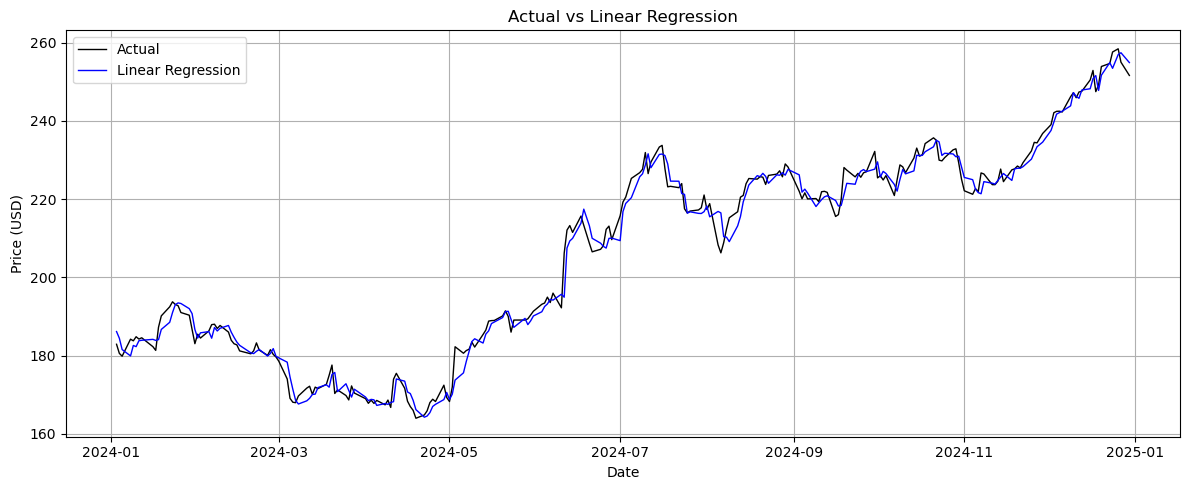

In [49]:
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label='Actual', color='black', linewidth=1)
plt.plot(y_test.index, y_pred_lr, label='Linear Regression', color='blue', linewidth=1)
plt.title('Actual vs Linear Regression')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

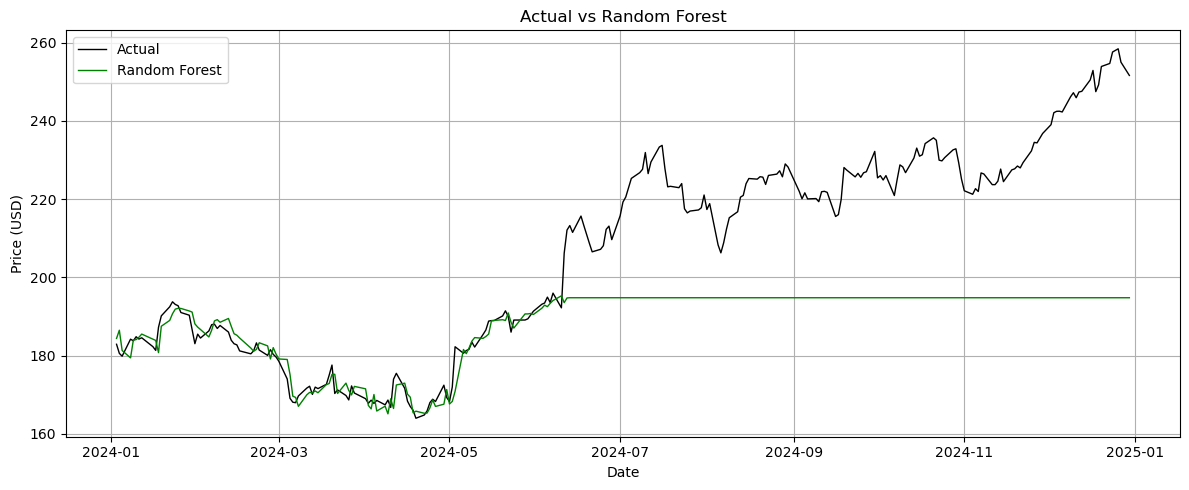

In [50]:
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label='Actual', color='black', linewidth=1)
plt.plot(y_test.index, y_pred_rf, label='Random Forest', color='green', linewidth=1)
plt.title('Actual vs Random Forest')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


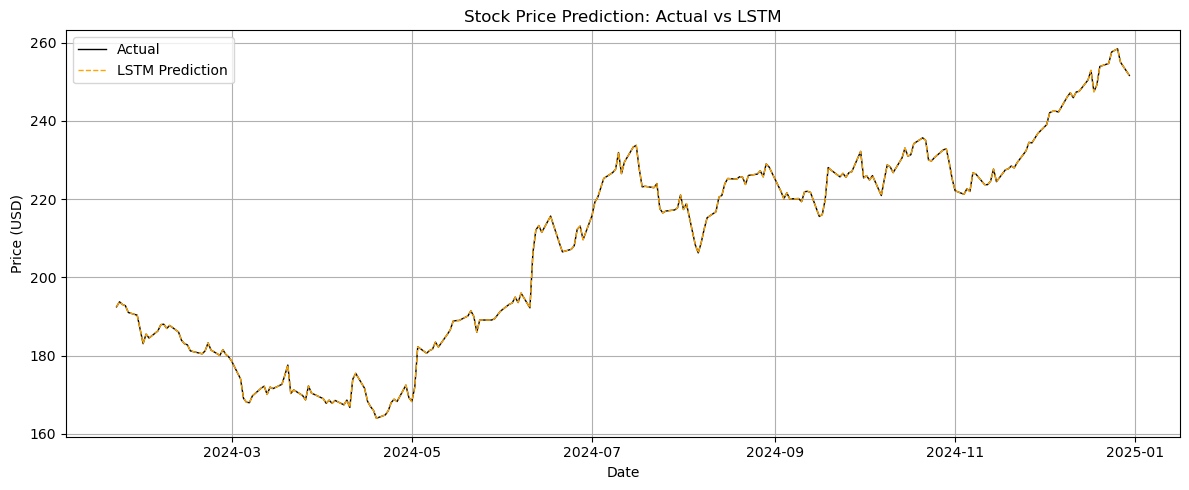

In [51]:
lstm_series = pd.Series(y_test_lstm_inv.squeeze(), index=y_test.index[-len(y_test_lstm_inv):])
actual_for_lstm = y_test[-len(y_test_lstm_inv):]

plt.figure(figsize=(12, 5))
plt.plot(actual_for_lstm.index, actual_for_lstm, label='Actual', color='black', linewidth=1)
plt.plot(lstm_series.index, lstm_series, label='LSTM Prediction', color='orange', linewidth=1, linestyle='--')

plt.title('Stock Price Prediction: Actual vs LSTM')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

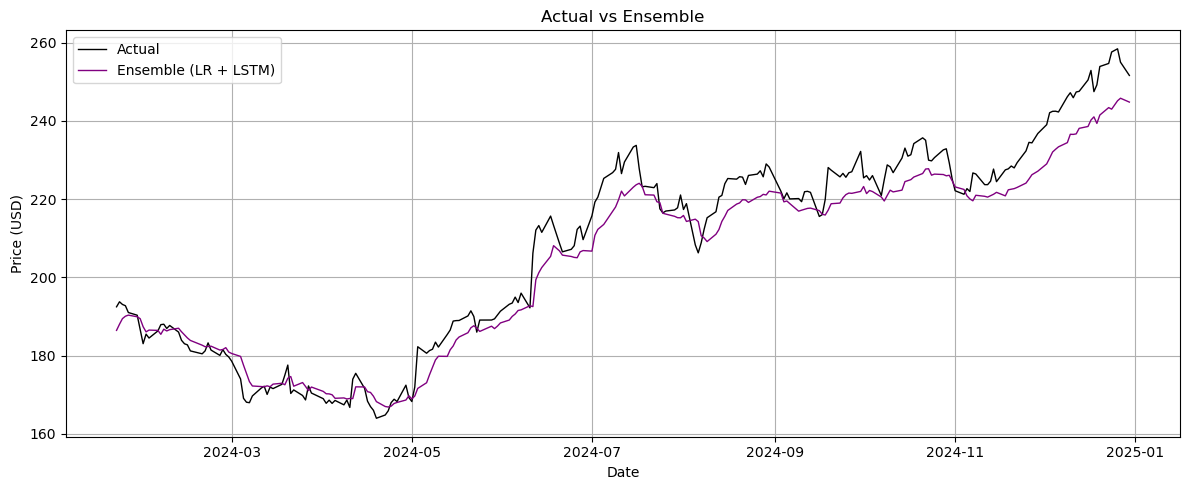

In [52]:
lstm_series = pd.Series(y_test_lstm_inv.squeeze(), index=y_test.index[-len(y_test_lstm_inv):])
ensemble_series = pd.Series(ensemble_pred.squeeze(), index=y_test.index[-len(y_test_lstm_inv):])
actual_for_lstm = y_test[-len(y_test_lstm_inv):]

plt.figure(figsize=(12,5))
plt.plot(actual_for_lstm.index, actual_for_lstm, label='Actual', color='black', linewidth=1)
plt.plot(ensemble_series.index, ensemble_series, label='Ensemble (LR + LSTM)', color='purple', linewidth=1)
plt.title('Actual vs Ensemble')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [53]:
import joblib
joblib.dump(lr, 'linear_regression_model.pkl')
print("Model saved as 'linear_regression_model.pkl'")

Model saved as 'linear_regression_model.pkl'



# Stock Price Prediction Using Machine Learning & Deep Learning

This project predicts Apple Inc. (AAPL) stock closing prices using historical data (2020-2024) with multiple models: Linear Regression, Random Forest, LSTM, and an Ensemble model.

---

## Project Overview

This project predicts Apple Inc. (AAPL) stock closing prices using historical stock market data from 2020 to 2024. It leverages multiple machine learning and deep learning models—including Linear Regression, Random Forest, Long Short-Term Memory (LSTM) networks, and an Ensemble model combining Linear Regression and LSTM—to forecast future stock prices based on past trends and patterns.

The goal is to demonstrate how different modeling techniques perform on time series financial data and to compare their prediction accuracy using key evaluation metrics such as RMSE, MAE, and R² score.

Key objectives include:
* Collecting and preprocessing real-world financial data using the Yahoo Finance API (yfinance)
* Engineering meaningful features such as lagged closing prices and moving averages to capture temporal dependencies
* Implementing and training models suitable for time series prediction, including both classical regression and modern deep learning approaches
* Evaluating and comparing model performance to identify the most effective forecasting method
* Visualizing actual vs. predicted prices to provide intuitive insights into model behavior and reliability

This project can serve as a foundation for more advanced stock price prediction systems, risk analysis, and financial decision-making tools by incorporating additional data sources and sophisticated algorithms.

---


## Features

- Download historical stock data from Yahoo Finance using `yfinance`  
- Feature engineering: lagged close price, moving averages (7-day, 14-day)  
- Train/test split preserving time series order  
- Models implemented:  
  - Linear Regression  
  - Random Forest Regressor  
  - LSTM (Long Short-Term Memory neural network)  
  - Ensemble of Linear Regression and LSTM  
- Performance evaluation with RMSE, MAE, and R² metrics  
- Visualization of actual vs predicted stock prices  

---

## Setup & Requirements

```bash
pip install -r requirements.txt
````

**Main dependencies:**

  * Python 3.8+
  * yfinance
  * pandas
  * numpy
  * matplotlib
  * scikit-learn
  * tensorflow (for LSTM)

-----

## Usage

1.  Clone the repository
2.  Run the data download and preprocessing script
3.  Train the models (Linear Regression, Random Forest, LSTM)
4.  Evaluate and visualize predictions

-----

## Results

| Model              | RMSE  | MAE   | R² Score | Interpretation                                                                                         |
| ------------------ | ----- | ----- | -------- | ------------------------------------------------------------------------------------------------------ |
| Linear Regression  | 2.86  | 2.16  | 0.99     | Best performance among individual models; closely fits actual stock prices.                            |
| Random Forest      | 25.74 | 19.13 | -0.02    | Poor performance; likely overfitting or unsuitable for this time-series data.                          |
| LSTM               | 7.00  | 5.66  | 0.93     | Strong performance leveraging sequential data patterns; slightly less accurate than Linear Regression. |
| Ensemble (LR+LSTM) | 4.41  | 3.53  | 0.97     | Combines strengths of LR and LSTM to improve accuracy over individual models.                          |


-----

## License

This project is licensed under the MIT License.

-----

## Acknowledgements

  * Yahoo Finance API (`yfinance`)
  * scikit-learn, TensorFlow libraries

-----
